In [99]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4 as ncf
import pandas as pd
from datetime import datetime, timedelta

In [165]:
# import data

# velocity
# import inverted velocities

fn = '/home/martin/projects/Hubbard2024/velocity/hubbard_inversion_2015-10-01_2023-01-01.nc'
data = ncf.Dataset(fn)
vx = np.array(data.variables['vx'][:])
vy = data.variables['vy'][:]
v = np.sqrt(vx**2+vy**2)
t = data.variables['time'][:]
# units: seconds since 2015-10-22 15:31:58
x = np.array(data.variables['x'][:])
y = np.array(data.variables['y'][:])

# choose a point for velocity

x0 = -3.311e6
y0 = 258000

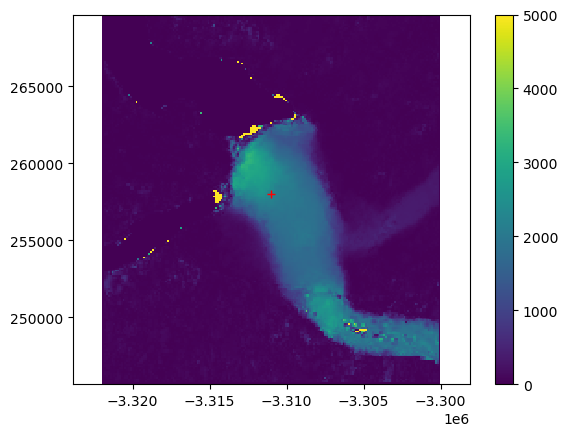

In [166]:
plt.pcolormesh(x,y,v[100,:,:],vmin=0,vmax=5000)
plt.axis('equal')
plt.plot(x0,y0,'r+')
plt.colorbar()

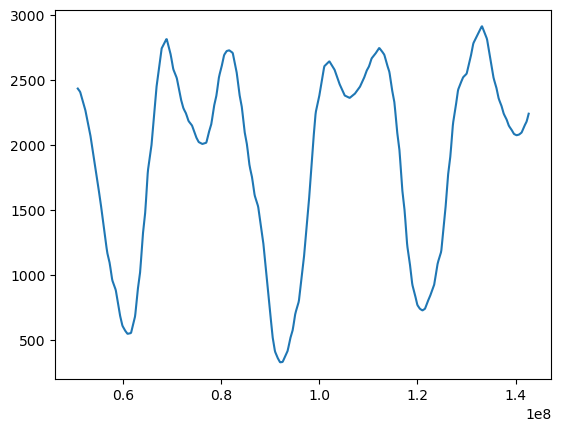

In [167]:
# extract velocity time series at point (x0,y0)

x_ind = np.argmin(np.abs(x-x0))
y_ind = np.argmin(np.abs(y-y0))

vel = v[:,y_ind,x_ind]

# interpolate to daily velocities 
# units: seconds since 2015-10-22 15:31:58
# create an array with daily velocities starting 1 June 2017 until 1 May 2020
spy = 86400*365 # seconds per year (non leap year)
spy_ly = 86400*366 # seconds per year (leap year)

offset = 2 + 28*60 + 8*3600 + (9+30+31)*86400 + spy_ly + (31+28+31+30+31)*86400
# end point May 1 2020
end_point = offset + (30+31+31+30+31+30+31)*86400 + 2*spy + (31+29+31+30)*86400

ti = np.arange(offset, end_point, 86400)

vi = np.interp(ti, t, vel)

t_dt = [datetime.strptime('2015-10-22 15:31:58', '%Y-%m-%d %H:%M:%S') + timedelta(seconds = int(i)) for i in ti]

plt.plot(ti,vi)

In [168]:
# load terminus data

fn = '/home/martin/projects/Hubbard2024/terminus_change/terminus_speed_weather_ocean.csv'
df = pd.read_csv(fn)
term = df['terminus advance (m)'].to_numpy()
T = df['AirTempC_Yakutat'].to_numpy()
df['first_day'] = pd.Timestamp('20170501')
t_term = (pd.to_datetime(df['Date'])- df['first_day']).dt.days
Delta_t = 31 # difference of when velocity time series starts (1 June 2017)

# create a time array from 1 May 2017 to 1 May 2020
total_days = 3*365 + 1 # 2020 is leap year
ti_term = np.arange(0, total_days, 1)
term_i = np.interp(ti_term, t_term, term)

Ti = np.interp(ti_term, t_term, T)

# create a cumulative PDD type graph that resets every year in October
may2oct = 31+30+31+31+30
jan2may = 31+29+31+30+11

pdd = np.zeros_like(Ti)
Ti[Ti<0] = 0
pdd[0:may2oct] = np.cumsum(Ti[0:may2oct])
pdd[may2oct:may2oct+365] = np.cumsum(Ti[may2oct:may2oct+365])
pdd[may2oct+365:may2oct+2*365] = np.cumsum(Ti[may2oct+365:may2oct+2*365])
pdd[may2oct+2*365:may2oct+3*365] = np.cumsum(Ti[may2oct+2*365:may2oct+3*365])
pdd[may2oct+3*365:may2oct+3*365+jan2may] = np.cumsum(Ti[may2oct+3*365:may2oct+3*365+jan2may])

In [169]:
# function that produces a velocity time series

def vs(x, term, Delta_t, vi):
    [alpha, L_off, beta, Delta_term, vmax, PDDmax] = x
    N = len(vi)
    t_array=np.arange(N)
    vterm = alpha*(term[t_array+Delta_t-int(Delta_term)]-L_off) + beta
    vr = vmax*(1-((pdd[t_array+Delta_t]-PDDmax)/PDDmax)**2)
    vr[vr<0] = 0
    
    return vr,vterm

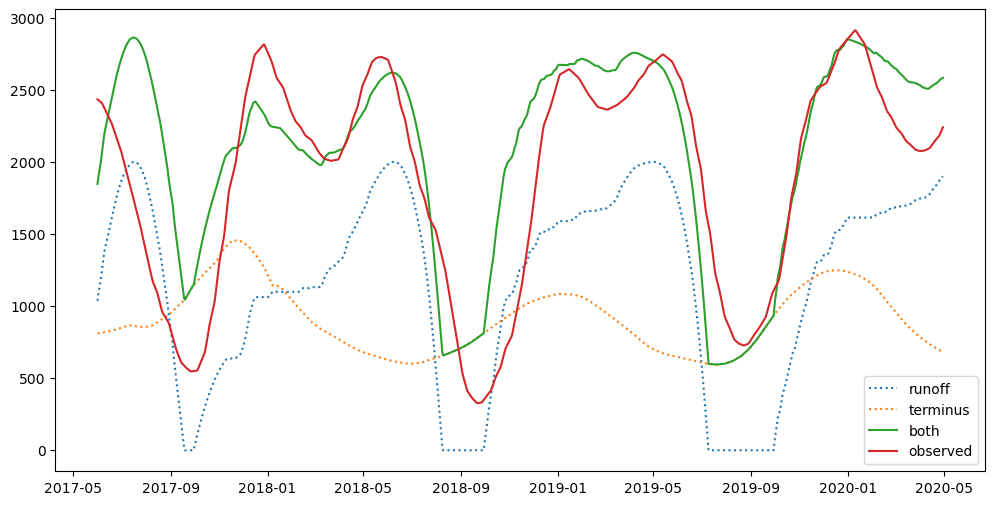

In [170]:
vr, vterm=vs([3,-100,0,20,2000,800],term, Delta_t, vi)

plt.figure(figsize=(12,6))
plt.plot(t_dt,vr, ':',label='runoff')
plt.plot(t_dt,vterm, ':', label='terminus')
plt.plot(t_dt,vterm+vr, label='both')
plt.plot(t_dt,vi, label='observed')
plt.legend()

In [171]:
# define a misfit function

def misfit(x,term, Delta_t, vi):
    [alpha, L_off, beta, Delta_term, vmax, PDDmax] = x
    vr, vterm = vs([alpha, L_off, beta, Delta_term, vmax, PDDmax],term, Delta_t, vi)
    vtot = vr+vterm
    # don't try to fit the first part of the curve, because cumulative runoff should include earlier data
    return np.sum((vi[150:450]-vtot[150:450])**2)
          

In [172]:
from scipy.optimize import minimize
xmin = minimize(misfit, [0,0,0,0,1000,1000], args=(term, Delta_t, vi), method='Nelder-Mead', tol=1e-6, options={'maxiter':10000})
xmin

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 30504226.339002345
             x: [ 4.112e+00 -3.645e+00  4.235e+00  6.000e+00  2.255e+03
                  8.076e+02]
           nit: 1029
          nfev: 1701
 final_simplex: (array([[ 4.112e+00, -3.645e+00, ...,  2.255e+03,
                         8.076e+02],
                       [ 4.112e+00, -3.645e+00, ...,  2.255e+03,
                         8.076e+02],
                       ...,
                       [ 4.112e+00, -3.645e+00, ...,  2.255e+03,
                         8.076e+02],
                       [ 4.112e+00, -3.645e+00, ...,  2.255e+03,
                         8.076e+02]]), array([ 3.050e+07,  3.050e+07,  3.050e+07,  3.050e+07,
                        3.050e+07,  3.050e+07,  3.050e+07]))

<Figure size 1200x600 with 0 Axes>

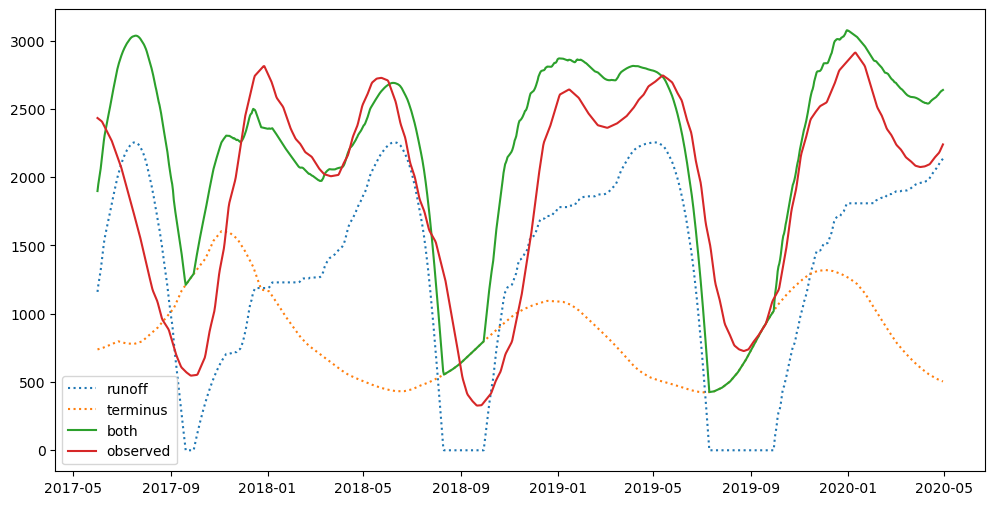

In [173]:
plt.figure(figsize=(12,6))
vr, vterm = vs(xmin['x'],term, Delta_t, vi)
v_tot = vr+vterm
plt.figure(figsize=(12,6))
plt.plot(t_dt,vr, ':', label='runoff')
plt.plot(t_dt,vterm, ':', label='terminus')
plt.plot(t_dt,vterm+vr, label='both')
plt.plot(t_dt,vi, label='observed')
plt.legend()

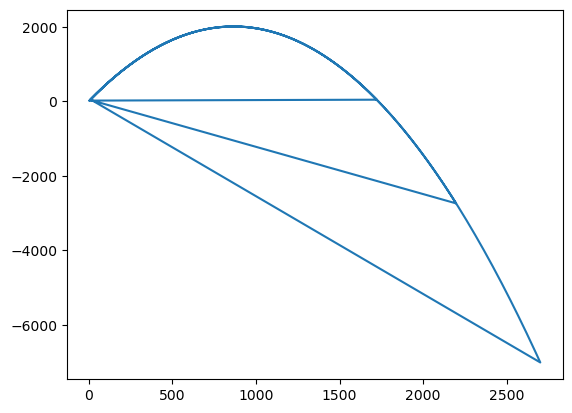

In [131]:
[alpha, beta, L_off, Delta_term, vmax, PDDmax] = xmin['x']
plt.plot(pdd, vmax*(1-((PDDmax-pdd)/PDDmax)**2))

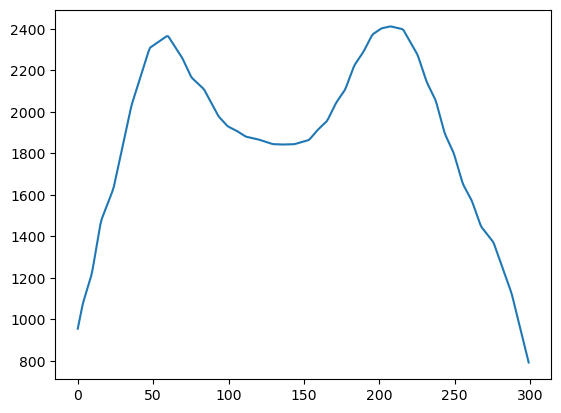

In [161]:
plt.plot(vi[150:450])

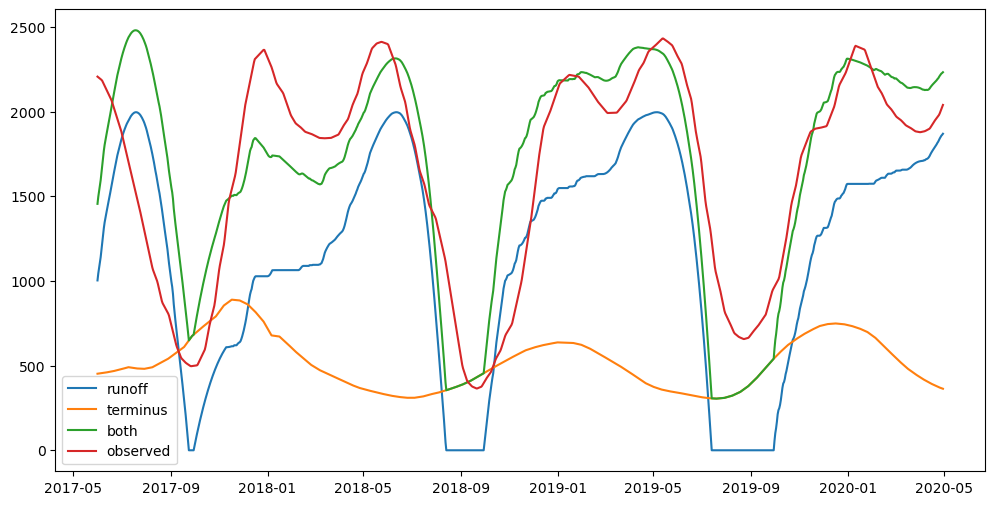

In [98]:
vr, vterm = vs_both(xmin['x'], term, Delta_t, vi)
plt.figure(figsize=(12,6))
plt.plot(t_dt,vr, label='runoff')
plt.plot(t_dt,vterm, label='terminus')
plt.plot(t_dt,vterm+vr, label='both')
plt.plot(t_dt,vi, label='observed')
plt.legend()